In [1]:
import numpy as np
import tensorflow as tf
import os
import copy
from math import pi
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from pandas import DataFrame as DF
from models import VGG_branch

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from classifier import preprocessing as prep

In [2]:
maximum = 0

In [3]:
def heatmap(matrix,title):
    df=DF(matrix,index=["Can","Paper","Glass","Plastic"],columns=["Can","Paper","Glass","Plastic"])
    plt.figure(figsize=(10,10))
    sns.heatmap(df, annot=True)
    plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Prediction",position = (0.5,1.0+0.05))
    plt.ylabel("Object")
    plt.title(title)

In [4]:
class_names = ['empty','can','paper','glass','plastic']

In [5]:
# label2idx_Dict = {
#                 'empty' : 0,
#                 'can' : 1,
#                 'paper' : 2,
#                 'glass' : 3,
#                 'plastic' : 4,
#             }

# idx2label_Dict = {
#     0 : 'empty',
#     1 : 'can',
#     2 : 'paper',
#     3 : 'glass',
#     4 : 'plastic',
# }
label2idx_Dict = {
                # 'empty' : 0,
                'can' : 0,
                'paper' : 1,
                'glass' : 2,
                'plastic' : 3,
            }

idx2label_Dict = {
    # 0 : 'empty',
    0 : 'can',
    1 : 'paper',
    2 : 'glass',
    3 : 'plastic',
}


dir_path = './data/train'
test_dir_path = './data/test'

def readNpy(dir_path):
    class_num = len(idx2label_Dict)

    Empty = list()
    Can = list()
    Paper = list()
    Glass = list()
    Plastic = list()
    Empty = np.array(Empty)
    Can = np.array(Can)
    Paper = np.array(Paper)
    Glass = np.array(Glass)
    Plastic = np.array(Plastic)

    for dir in os.listdir(dir_path):
        d_path = os.path.join(dir_path, dir)
        file_list = os.listdir(d_path)
        for file in file_list:
            file_path = os.path.join(d_path, file)
            if dir == 'can':
                if len(Can) == 0:
                    Can = np.load(file_path, allow_pickle=True)
                else :
                    Can = np.append(Can, np.load(file_path), axis = 0)
            elif dir == 'paper':
                if len(Paper) == 0:
                    Paper = np.load(file_path, allow_pickle=True)
                else :
                    Paper = np.append(Paper, np.load(file_path), axis = 0)
            elif dir == 'glass':
                if len(Glass) == 0:
                    Glass = np.load(file_path, allow_pickle=True)
                else:
                    Glass = np.append(Glass, np.load(file_path), axis = 0)
            elif dir == 'plastic':
                if len(Plastic) == 0:
                    Plastic = np.load(file_path, allow_pickle=True)
                else:
                    Plastic = np.append(Plastic, np.load(file_path), axis = 0)
            # elif dir == 'empty':
            #     if len(Empty) == 0:
            #         Empty = np.load(file_path, allow_pickle=True)
            #     else:
            #         Empty = np.append(Empty, np.load(file_path), axis = 0)
    bound = Can.shape[1]
    # Empty_label = np.full((Empty.shape[0], class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['empty']])
    Can_label = np.full((Can.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['can']])
    Paper_label = np.full((Paper.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['paper']])
    Glass_label = np.full((Glass.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['glass']])
    Plastic_label = np.full((Plastic.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['plastic']])

    # Empty = np.concatenate((Empty, Empty_label), axis=1)
    Can = np.concatenate((Can, Can_label), axis=1)
    Paper = np.concatenate((Paper, Paper_label), axis=1)
    Glass = np.concatenate((Glass, Glass_label), axis=1)
    Plastic = np.concatenate((Plastic, Plastic_label), axis=1)
    array = Can
    array = np.append(array, Paper, axis = 0)
    array = np.append(array, Glass, axis = 0)
    array = np.append(array, Plastic, axis = 0)
    # array = np.append(array, Empty, axis = 0)
    s = np.arange(array.shape[0])
    np.random.shuffle(s)
    array_s = array[s]

    X = array_s[:,:bound]
    Y = np.real(array_s[:,bound:])
    return copy.deepcopy(X), copy.deepcopy(Y)

X, Y = readNpy(dir_path)

test_X, test_Y= readNpy(test_dir_path)

In [6]:
print(np.max(np.abs(X)))
print(np.max(np.angle(X)))

1563.3131995860588
3.141592653589793


In [7]:
print(X.shape)

(460, 167)


In [8]:
def seperater(arr):
    global maximum
    pre_data = arr
    amp = np.abs(pre_data)
    amp = amp / maximum
    phs = np.angle(pre_data)
    # phs = (phs - (- pi)) / (pi - (- pi))
    sin = np.sin(phs)
    sin = (sin + 1) / 2
    seperated_data = np.stack((amp.T,sin.T), axis=0)
    seperated_data = np.expand_dims(seperated_data, axis=0)
    return np.array(seperated_data)

In [9]:
def dataSeperator(arr):
    temp = copy.deepcopy(seperater(arr[0]))
    for i in range(1, len(arr)):
        temp = np.concatenate((temp, seperater(arr[i])), axis=0)
    return temp

In [10]:
maximum = 1
Split_X = dataSeperator(X)
test_Split_X = dataSeperator(test_X)

In [29]:
maximum = np.max(np.abs(X))
Split_X_n = dataSeperator(X)
test_Split_X_n = dataSeperator(test_X)

1563.3131995860588


In [12]:
print(Y.shape, Split_X_n.shape)

(460, 4) (460, 2, 167)


In [13]:
def plotting(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [14]:
print(np.argmax(Y[2]))

0


In [15]:
for i in label2idx_Dict:
    print(i)

can
paper
glass
plastic


In [16]:
def data_plot(array, Y):
    x = np.linspace(13,18,array.shape[2])
    for i in label2idx_Dict:
        for j in range(len(array)):
            if np.argmax(Y[j]) == label2idx_Dict[i]:
                plt.subplot(len(label2idx_Dict) * 2,1, label2idx_Dict[i]*2 + 1)
                plt.title(i)
                plt.plot(x ,array[j][0])
                plt.subplot(len(label2idx_Dict) * 2,1, (label2idx_Dict[i]*2 + 2))
                plt.plot(x, array[j][1])
    
    plt.show

In [17]:
plt.rcParams["figure.figsize"] = (10,40)

In [18]:
# data_plot(Split_X_n, Y)

In [19]:
print(Split_X_n.shape)

(460, 2, 167)


In [20]:
# def VGG_branch(X, Y, test_X, test_Y, cp_filepath, EPOCH=10):
    
#     amp_input = keras.Input(shape=(X.shape[2],1), name="amplitude")
#     phs_input = keras.Input(shape=(X.shape[2],1), name='phase')
    
#     amp_features = layers.Conv1D(64, (3), activation = 'relu', input_shape = (X.shape[2], 1), padding = 'same')(amp_input)
#     amp_features = layers.Conv1D(64, (3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.MaxPool1D(2)(amp_features)
#     amp_features = layers.Conv1D(128, (3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.Conv1D(128, (3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.MaxPool1D(2)(amp_features)
#     amp_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(amp_features)
#     amp_features = layers.MaxPool1D(2)(amp_features)
#     amp_features = layers.Flatten()(amp_features)

#     phs_features = layers.Conv1D(64, (3), activation = 'relu', input_shape = (X.shape[2], 1), padding = 'same')(phs_input)
#     phs_features = layers.Conv1D(64, (3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.MaxPool1D(2)(phs_features)
#     phs_features = layers.Conv1D(128, (3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.Conv1D(128, (3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.MaxPool1D(2)(phs_features)
#     phs_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.Conv1D(256,(3), activation = 'relu', padding = 'same')(phs_features)
#     phs_features = layers.MaxPool1D(2)(phs_features)
#     phs_features = layers.Flatten()(phs_features)

#     x = layers.concatenate([amp_features, phs_features], axis = -1)
#     x = layers.Dense(4096, activation = 'relu')(x)
#     x = layers.Dropout(0.9)(x)
#     x = layers.Dense(4096, activation = 'relu')(x)
#     x = layers.Dropout(0.9)(x)
#     # material_output = layers.Dense(5, activation = 'softmax', name = 'material_output')(x)
#     material_output = layers.Dense(4, activation = 'softmax', name = 'material_output')(x)

#     model = keras.Model(inputs = [amp_input, phs_input],
#                         outputs = [material_output],)

#     model.summary()
#     keras.utils.plot_model(model, "./branced_model.png", show_shapes=True)
#     model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#     checkpoint_filepath = cp_filepath
#     callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath = './model/' + checkpoint_filepath,
#         monitor='val_accuracy',
#         mode='max',
#         save_best_only = True,
#         save_weigths_only = False,
#     )
#     log_dir = './logs/fit/'
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

#     return model.fit(
#     {"amplitude": X[:,0,:], "phase": X[:,1,:]},
#     {"material_output": Y},
#     batch_size = 32,
#     epochs=EPOCH,
#     validation_data = ({"amplitude" : test_X[:,0,:], "phase": test_X[:,1,:]}, {"material_output" : test_Y}),
#     callbacks = [callback, tensorboard_callback]
#     )

In [21]:
checkpoint_filepath = 'branch_model'

In [22]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './model/' + checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weigths_only = False,
)
log_dir = './logs/fit/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [23]:
print(Split_X.shape)
model = VGG_branch(Split_X.shape[2])
# history=model.fit(
#     {"amplitude": Split_X[:,0,:], "phase": Split_X[:,1,:]},
#     {"material_output": Y},
#     batch_size = 32,
#     epochs=30,
#     validation_data = ({"amplitude" : test_Split_X[:,0,:], "phase": test_Split_X[:,1,:]}, {"material_output" : test_Y}),
#     callbacks = [callback, tensorboard_callback]
#     )

history=model.fit(
    Split_X,
    Y,
    batch_size = 32,
    epochs=30,
    validation_data = (test_Split_X, test_Y),
    callbacks = [callback, tensorboard_callback]
    )

(460, 2, 167)
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(None, 167, 1)
167


2022-07-12 11:17:45.361817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 11:17:45.361930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 167)]     0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 167)         0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 167)         0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

2022-07-12 11:17:46.032279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-07-12 11:17:46.422532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 8.8277 - accuracy: 0.2717

2022-07-12 11:17:47.648953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-12 11:17:48.311253: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/branch_model/assets
15/15 [==============================] - 11s 753ms/step - loss: 8.8277 - accuracy: 0.2717 - val_loss: 1.3692 - val_accuracy: 0.2786
Epoch 2/30
15/15 [==============================] - 6s 431ms/step - loss: 1.3761 - accuracy: 0.3043 - val_loss: 1.3623 - val_accuracy: 0.2786
Epoch 3/30
15/15 [==============================] - 9s 652ms/step - loss: 1.3267 - accuracy: 0.3283 - val_loss: 1.3423 - val_accuracy: 0.6929
Epoch 4/30
15/15 [==============================] - 7s 455ms/step - loss: 1.2849 - accuracy: 0.3783 - val_loss: 1.3217 - val_accuracy: 0.2643
Epoch 5/30
15/15 [==============================] - 6s 431ms/step - loss: 1.1481 - accuracy: 0.4739 - val_loss: 1.2673 - val_accuracy: 0.4929
Epoch 6/30
15/15 [==============================] - 6s 444ms/step - loss: 1.1463 - accuracy: 0.4304 - val_loss: 1.2235 - val_accuracy: 0.4214
Epoch 7/30
15/15 [==============================] - 6s 442ms/step - loss: 1.1162 - accuracy: 0.

In [24]:
print(max(history.history['val_accuracy']))

0.7857142686843872


In [25]:
checkpoint_filepath = 'branch_model_norm'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './model/' + checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weigths_only = False,
)

In [30]:
norm_model = VGG_branch(Split_X_n.shape[2])
norm_hist = norm_model.fit(
    Split_X_n,
    Y,
    batch_size = 32,
    epochs=30,
    validation_data = (test_Split_X_n, test_Y),
    callbacks = [callback, tensorboard_callback]
)

(None, 167, 1)
167
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 167)]     0           []                               
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 167)         0           ['input_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 167)         0           ['input_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                         

2022-07-12 11:51:07.638056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.3981 - accuracy: 0.2717

2022-07-12 11:51:09.036827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 8s 498ms/step - loss: 1.3981 - accuracy: 0.2717 - val_loss: 1.3554 - val_accuracy: 0.2143
Epoch 2/30
15/15 [==============================] - 7s 460ms/step - loss: 1.4103 - accuracy: 0.2413 - val_loss: 1.3746 - val_accuracy: 0.5000
Epoch 3/30
15/15 [==============================] - 6s 387ms/step - loss: 1.3874 - accuracy: 0.2696 - val_loss: 1.3736 - val_accuracy: 0.2143
Epoch 4/30
15/15 [==============================] - 6s 413ms/step - loss: 1.3980 - accuracy: 0.2630 - val_loss: 1.3680 - val_accuracy: 0.3429
Epoch 5/30
15/15 [==============================] - 11s 734ms/step - loss: 1.3713 - accuracy: 0.2913 - val_loss: 1.3436 - val_accuracy: 0.5071
Epoch 6/30
15/15 [==============================] - 10s 710ms/step - loss: 1.3514 - accuracy: 0.3348 - val_loss: 1.3418 - val_accuracy: 0.5429
Epoch 7/30
15/15 [==============================] - 7s 475ms/step - loss: 1.3103 - accuracy: 0.3739 - val_loss: 1.3004 - val_accuracy: 0.4286
Epoch 8/30
15/1

In [31]:
print(max(norm_hist.history['val_accuracy']))

0.6142857074737549


In [28]:
VGG_branch_model = tf.keras.models.load_model('./model/branch_model')
VGG_branch_pred = VGG_branch_model.predict({"amplitude": test_Split_X_n[:,0,:], "phase": test_Split_X_n[:,1,:]})
VGG_branch_evl = VGG_branch_model.evaluate({"amplitude": test_Split_X_n[:,0,:], "phase": test_Split_X_n[:,1,:]}, {"material_output" : test_Y})
print(VGG_branch_evl)
test_Y_class = np.argmax(test_Y, axis = -1)
VGG_branch_cm = confusion_matrix(test_Y_class, np.argmax(VGG_branch_pred, axis = -1))

print(VGG_branch_cm)
heatmap(VGG_branch_cm, 'VGG_branch_cm')

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/radar/lib/python3.9/site-packages/keras/engine/input_spec.py", line 182, in assert_input_compatibility
        raise ValueError(f'Missing data for input "{name}". '

    ValueError: Missing data for input "input_1". You passed a data dictionary with keys ['amplitude', 'phase']. Expected the following keys: ['input_1']


2022-05-11 23:48:27.838551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - loss: 1.0511 - accuracy: 0.8125

2022-05-11 23:48:28.167310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 38ms/step - loss: 1.0512 - accuracy: 0.8071
[1.0511720180511475, 0.8071428537368774]
[[19  0  9  2]
 [ 0  0  0 10]
 [ 0  0 28  2]
 [ 0  1  3 66]]


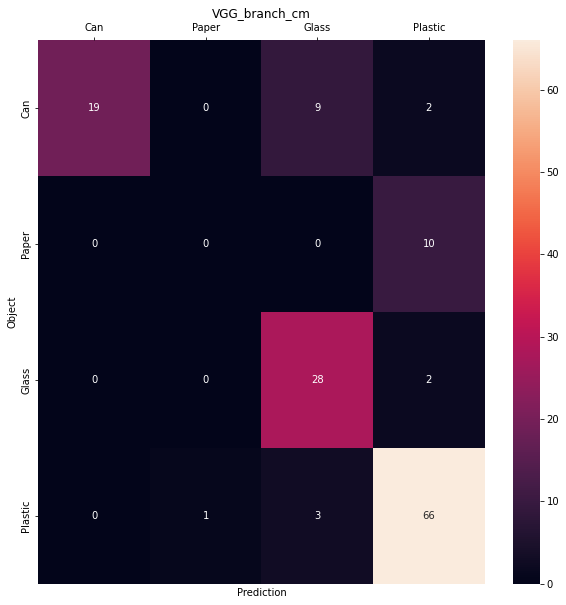

In [ ]:
VGG_branch_model_norm = tf.keras.models.load_model('./model/branch_model_norm')
VGG_branch_norm_pred = VGG_branch_model_norm.predict({"amplitude": test_Split_X_n[:,0,:], "phase": test_Split_X_n[:,1,:]})
VGG_branch_norm_evl = VGG_branch_model_norm.evaluate({"amplitude": test_Split_X_n[:,0,:], "phase": test_Split_X_n[:,1,:]}, {"material_output" : test_Y})
print(VGG_branch_norm_evl)
test_Y_class = np.argmax(test_Y, axis = -1)
VGG_branch_norm_cm = confusion_matrix(test_Y_class, np.argmax(VGG_branch_norm_pred, axis = -1))

print(VGG_branch_norm_cm)
heatmap(VGG_branch_norm_cm, 'VGG_branch_cm')

In [ ]:
def classifier_data(x):
    abs_x = np.abs(x)
    return np.concatenate((abs_x, np.expand_dims(np.max(abs_x, axis = 1), axis = 1), np.expand_dims(np.min(abs_x, axis = 1), axis = 1), np.expand_dims(np.mean(abs_x, axis = 1), axis = 1)), axis = 1)

In [ ]:
X_c = classifier_data(X)
test_X_c = classifier_data(test_X)
Y_c = np.argmax(Y, axis = 1)
test_Y_c = np.argmax(test_Y, axis = 1)

In [ ]:
print(X_c.shape)

(460, 170)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=10, random_state=0)
model.fit(X_c, Y_c)

RandomForestClassifier(n_estimators=10, random_state=0)

In [ ]:
model.score(test_X_c, test_Y_c)

0.42857142857142855

In [ ]:
rf_cm = confusion_matrix(test_Y_c, model.predict(test_X_c))

In [ ]:
rf_cm

array([[18,  0,  9,  3],
       [ 0,  0,  0, 10],
       [ 3,  0, 17, 10],
       [ 1, 21, 23, 25]])

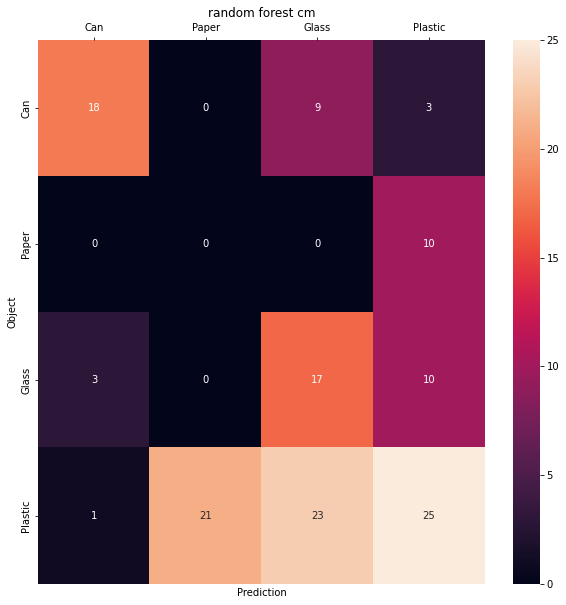

In [ ]:
heatmap(rf_cm, 'random forest cm')